In [1]:
import numpy as np

# Constants
m_e = 0.511e-3  # Electron mass in GeV
M_p = 0.938     # Proton mass in GeV
alpha = 1/137   # Fine structure constant

def scattered_energy(E_beam, theta):
    """Returns scattered electron energy E' for given beam energy and angle."""
    return E_beam / (1 + (E_beam/M_p)*(1 - np.cos(theta)))

def momentum_transfer(E, Ep, theta):
    """Returns Q^2 from energies and angle."""
    return 4 * E * Ep * np.sin(theta/2)**2


In [2]:
def generate_event(E_beam):
    # Uniform in cos(theta) to avoid forward peaking bias
    cos_theta = np.random.uniform(-1, 1)
    theta = np.arccos(cos_theta)
    
    Ep = scattered_energy(E_beam, theta)
    Q2 = momentum_transfer(E_beam, Ep, theta)
    
    return theta, Ep, Q2


In [3]:
def GE_dipole(Q2):
    return 1 / (1 + Q2/0.71)**2

def differential_cross_section(E, Ep, theta):
    q2 = momentum_transfer(E, Ep, theta)
    G_E = GE_dipole(q2)
    term1 = (alpha**2 * np.cos(theta/2)**2) / (4 * E**2 * np.sin(theta/2)**4)
    return term1 * (Ep/E)**2 * G_E**2


In [4]:
def weighted_event(E_beam, max_trials=1000):
    for _ in range(max_trials):
        theta = np.arccos(np.random.uniform(-1, 1))
        Ep = scattered_energy(E_beam, theta)
        dsigma = differential_cross_section(E_beam, Ep, theta)
        if np.random.uniform(0, 1) < dsigma / 1e-4:  # scale factor
            Q2 = momentum_transfer(E_beam, Ep, theta)
            return theta, Ep, Q2
    return None  # no accepted event


In [5]:
def within_acceptance(theta, Ep):
    return 0.01 < theta < np.pi - 0.01 and 0.2 < Ep < 4.0

def smear_energy(Ep, resolution=0.01):
    return np.random.normal(Ep, resolution * Ep)


In [6]:
import matplotlib.pyplot as plt

def generate_events(E_beam, N=10000):
    events = []
    for _ in range(N):
        res = weighted_event(E_beam)
        if res:
            theta, Ep, Q2 = res
            if within_acceptance(theta, Ep):
                Ep_smeared = smear_energy(Ep)
                events.append((theta, Ep_smeared, Q2))
    return np.array(events)


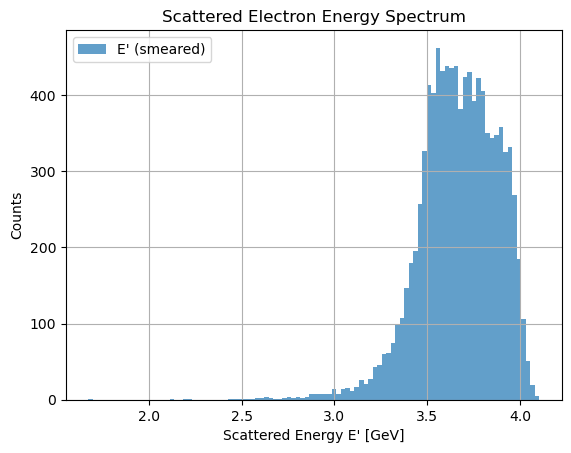

In [7]:
events = generate_events(4.0, 10000)  # 4 GeV beam

plt.figure()
plt.hist(events[:, 1], bins=100, alpha=0.7, label="E' (smeared)")
plt.xlabel("Scattered Energy E' [GeV]")
plt.ylabel("Counts")
plt.title("Scattered Electron Energy Spectrum")
plt.legend()
plt.grid()
plt.show()


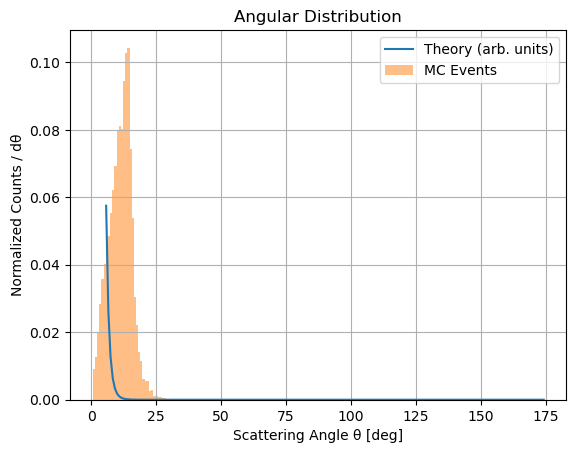

In [9]:
thetas = np.linspace(0.1, np.pi - 0.1, 200)
Eps = scattered_energy(4.0, thetas)
dsigmas = [differential_cross_section(4.0, ep, th) for ep, th in zip(Eps, thetas)]

plt.figure()
plt.plot(thetas * 180 / np.pi, dsigmas, label="Theory (arb. units)")
plt.hist(events[:, 0] * 180 / np.pi, bins=50, density=True, alpha=0.5, label="MC Events")
plt.xlabel("Scattering Angle θ [deg]")
plt.ylabel("Normalized Counts / dθ")
plt.title("Angular Distribution")
plt.legend()
plt.grid()
plt.show()
